In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd

In [2]:
#path_list = glob.glob("local_multilayer/*")
# path_list = glob.glob("long_local/*")
path_list = glob.glob("../results")
path_list

['long_local/multi_layer_run_3.pkl',
 'long_local/multi_layer_run_4.pkl',
 'long_local/multi_layer_run_2.pkl',
 'long_local/multi_layer_run_0.pkl',
 'long_local/multi_layer_run_1.pkl']

In [3]:
eg_data = pd.read_pickle(path_list[0])

In [4]:
all_model_keys = list(eg_data.keys())
print(eg_data.keys())
print(eg_data["contrastive_hebb"].keys())
[print(key, type(val)) for key, val in eg_data["contrastive_hebb"].items()]
print("weight shape", eg_data["contrastive_hebb"]["learned_W"][-1][0].shape)
print("angles shape", eg_data["contrastive_hebb"]["data"].angles.shape)
print("n sampled weights", len(eg_data["contrastive_hebb"]["learned_W"]))
np.equal(eg_data["gradient_descent"]["learned_W"][0][0], eg_data["gradient_descent"]["learned_W"][-1][0]).all()

dict_keys(['gradient_descent', 'contrastive', 'quasi_predictive', 'hebbian', 'anti_hebbian', 'contrastive_hebb', 'contrastive_anti_hebb', 'quasi_predictive_hebb', 'quasi_predictive_anti_hebb'])
dict_keys(['loss', 'learned_W', 'W_grad', 'save_every', 'data', 'learning_rate', 'tuned_neurons_width'])
loss <class 'numpy.ndarray'>
learned_W <class 'list'>
W_grad <class 'list'>
save_every <class 'int'>
data <class 'angle_discrimination_task.AngleDiscriminationTask'>
learning_rate <class 'float'>
tuned_neurons_width <class 'int'>
weight shape (60, 100)
angles shape (100,)
n sampled weights 71


False

In [5]:
def compute_mean_func(path_list, model_key, func, func_kwargs):
    all_quant = []
    for path in path_list:
        results = pd.read_pickle(path)[model_key]
        all_quant.append(func(results, **func_kwargs))
    all_quant = np.stack(all_quant, axis=0)
    return np.mean(all_quant, axis=0), np.std(all_quant, axis=0)

In [6]:
def loss_func(results):
    return np.array(results["loss"])

In [7]:
def plt_errorbar(x, mean, std, ax, lw=3, color="C0", alpha=0.4, label=""):
    ax.fill_between(x, y1=mean+2*std, y2=mean-2*std, color="C0", alpha=alpha)
    ax.plot(x, mean, lw=lw, color=color, label=label)
    return ax

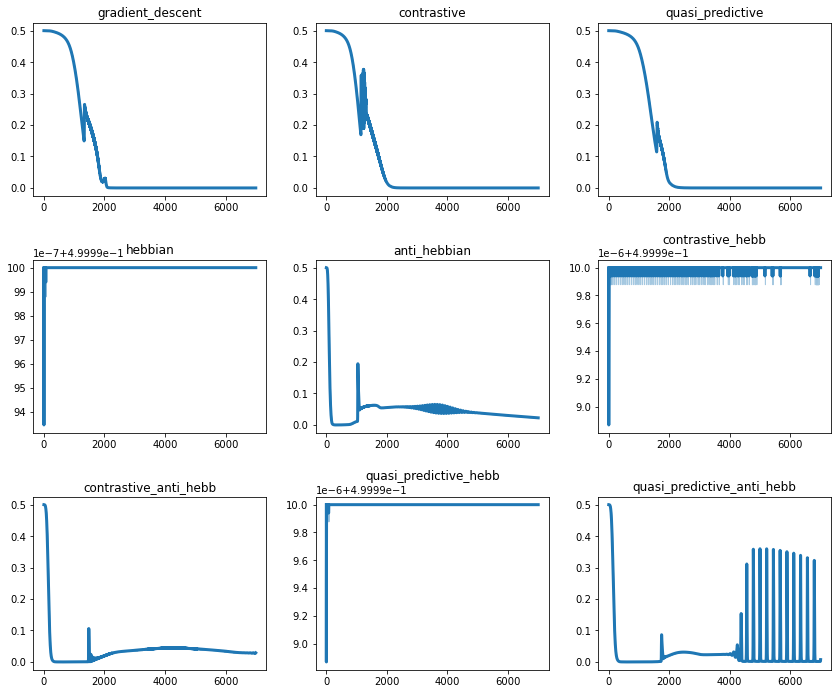

In [8]:
f, ax = plt.subplots(3, 3, figsize=(12, 10))
ax = ax.flatten()
for i, model_key in enumerate(all_model_keys):
    mean_loss, std_loss = compute_mean_func(path_list, model_key, loss_func, func_kwargs={})
    ax[i] = plt_errorbar(list(np.arange(len(mean_loss))), mean_loss, std_loss, ax=ax[i])
    ax[i].set_title(model_key)
f.tight_layout(pad=2.0)

In [18]:
def slope_PO_TO(results, normalize_tuning=False, weight_index=-1, layer=0, TO=90.0):
    
    data = results["data"]
    
    W = np.tanh(np.array(results["learned_W"][weight_index][0]))
    if layer != 0:
        
        for i in range(1, layer+1):
            W = np.tanh(np.array(results["learned_W"][weight_index][i]) @ W)
    
    angles = data.angles
    
    PO_index = np.argmax(W, axis=1)
    if normalize_tuning:
        W = W/np.amax(W, axis=1)[:, np.newaxis]
    
    PO = angles[PO_index]
    slopes = np.diff(np.concatenate([W, W[:, 1][:, np.newaxis]], axis=1), axis=1)
    x_axis = PO - TO
    TO_index = np.argmin(np.abs(angles-TO))
    y_axis = slopes[:, TO_index]
    
    sort_index = np.argsort(x_axis)
    x_axis = x_axis[sort_index]
    y_axis = y_axis[sort_index]
    return x_axis, y_axis

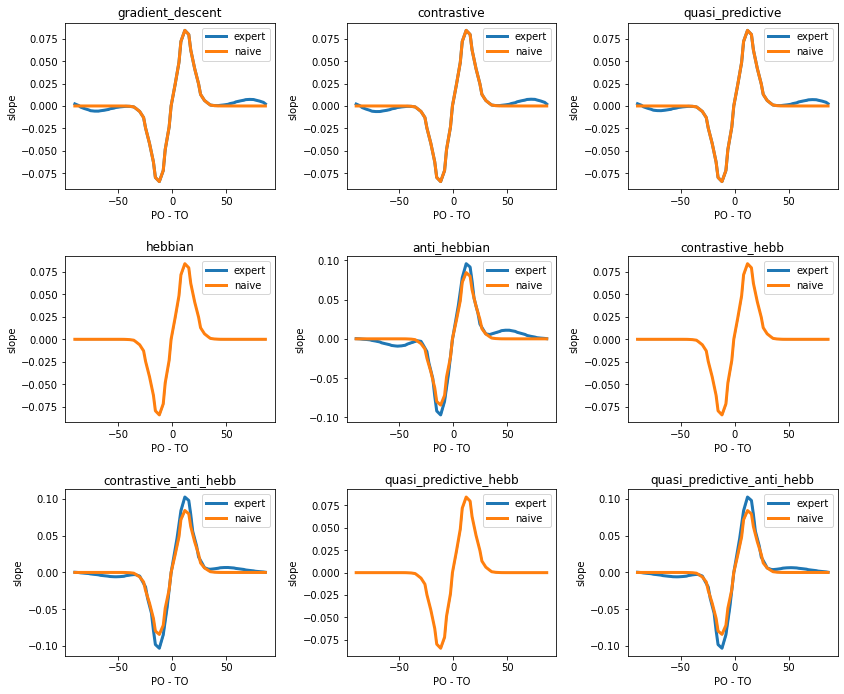

In [19]:
f, ax = plt.subplots(3, 3, figsize=(12, 10))
ax = ax.flatten()
for i, model_key in enumerate(all_model_keys):
    mean_x_y, std_x_y = compute_mean_func(path_list, model_key, slope_PO_TO, func_kwargs={"weight_index": -1})
    x, y, y_err = mean_x_y[0], mean_x_y[1], std_x_y[1]
    ax[i] = plt_errorbar(x, y, y_err, ax=ax[i], label="expert")
    
    mean_x_y, std_x_y = compute_mean_func(path_list, model_key, slope_PO_TO, func_kwargs={"weight_index": 0})
    x, y, y_err = mean_x_y[0], mean_x_y[1], std_x_y[1]
    ax[i] = plt_errorbar(x, y, y_err, ax=ax[i], color="C1", label="naive")
    ax[i].legend()
    ax[i].set_title(model_key)
    ax[i].set_xlabel("PO - TO")
    ax[i].set_ylabel("slope")
f.tight_layout(pad=2.0)

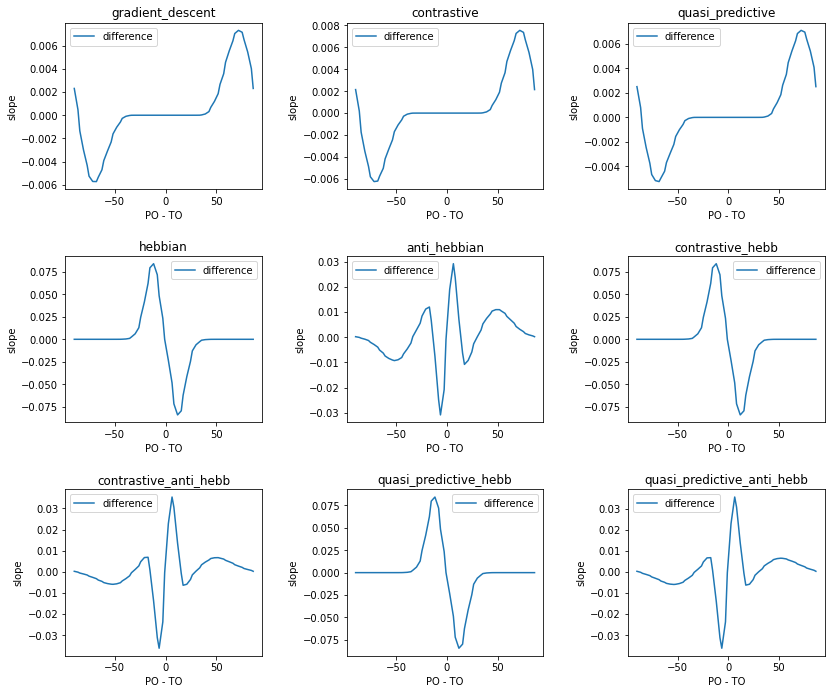

In [20]:
f, ax = plt.subplots(3, 3, figsize=(12, 10))
ax = ax.flatten()
for i, model_key in enumerate(all_model_keys):
    expert_mean_x_y, expert_std_x_y = compute_mean_func(path_list, model_key, slope_PO_TO, func_kwargs={"weight_index": -1})
    expert_x, expert_y, expert_y_err = expert_mean_x_y[0], expert_mean_x_y[1], expert_std_x_y[1]
    
    mean_x_y, std_x_y = compute_mean_func(path_list, model_key, slope_PO_TO, func_kwargs={"weight_index": 0})
    x, y, y_err = mean_x_y[0], mean_x_y[1], std_x_y[1]
    # print(np.equal(y, expert_y).all())
    #ax[i] = plt_errorbar(x, y, y_err, ax=ax[i], color="C1", label="naive")
    ax[i].plot(x, expert_y-y, label="difference")
    
    ax[i].legend()
    ax[i].set_title(model_key)
    ax[i].set_xlabel("PO - TO")
    ax[i].set_ylabel("slope")
    # print(model_key)
    # print("expert", expert_y)
    # print("naive", y)
f.tight_layout(pad=2.0)

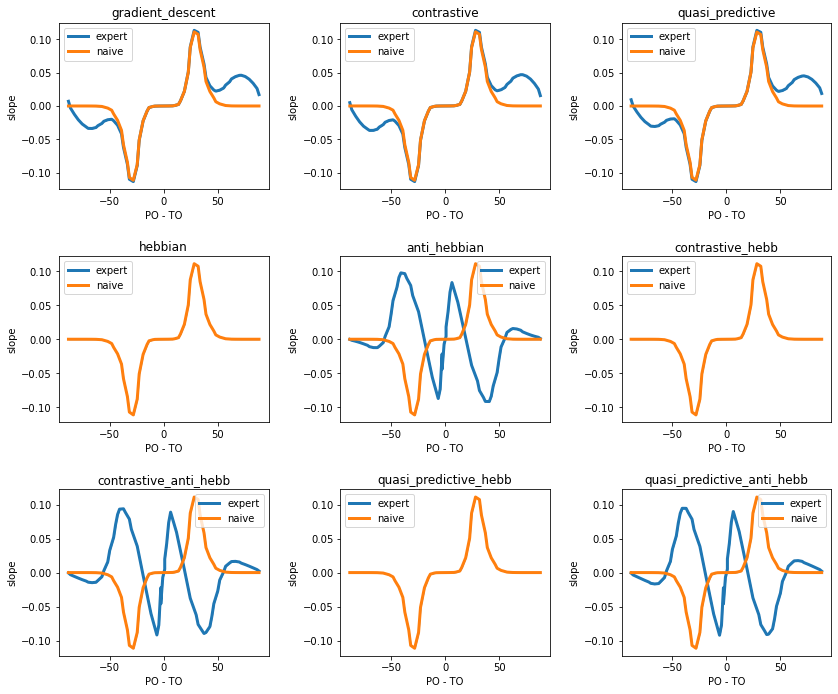

In [21]:
f, ax = plt.subplots(3, 3, figsize=(12, 10))
ax = ax.flatten()
for i, model_key in enumerate(all_model_keys):
    mean_x_y, std_x_y = compute_mean_func(path_list, model_key, slope_PO_TO, func_kwargs={"weight_index": -1, "layer":1})
    x, y, y_err = mean_x_y[0], mean_x_y[1], std_x_y[1]
    ax[i] = plt_errorbar(x, y, y_err, ax=ax[i], label="expert")
    
    mean_x_y, std_x_y = compute_mean_func(path_list, model_key, slope_PO_TO, func_kwargs={"weight_index": 0, "layer":1})
    x, y, y_err = mean_x_y[0], mean_x_y[1], std_x_y[1]
    ax[i] = plt_errorbar(x, y, y_err, ax=ax[i], color="C1", label="naive")
    ax[i].legend()
    ax[i].set_title(model_key)
    ax[i].set_xlabel("PO - TO")
    ax[i].set_ylabel("slope")
f.tight_layout(pad=2.0)

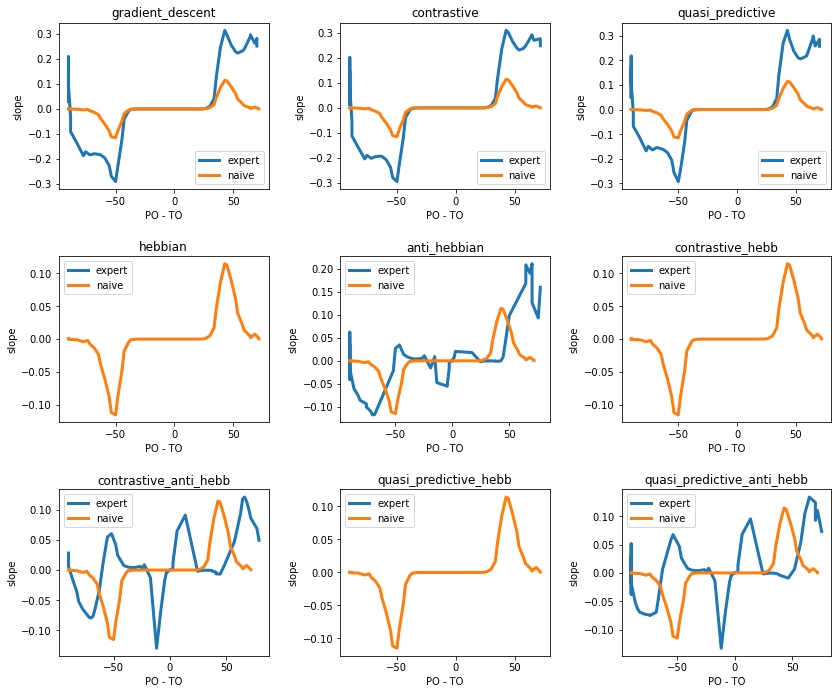

In [22]:
f, ax = plt.subplots(3, 3, figsize=(12, 10))
ax = ax.flatten()
for i, model_key in enumerate(all_model_keys):
    mean_x_y, std_x_y = compute_mean_func(path_list, model_key, slope_PO_TO, func_kwargs={"weight_index": -1, "layer":2})
    x, y, y_err = mean_x_y[0], mean_x_y[1], std_x_y[1]
    ax[i] = plt_errorbar(x, y, y_err, ax=ax[i], label="expert")
    
    mean_x_y, std_x_y = compute_mean_func(path_list, model_key, slope_PO_TO, func_kwargs={"weight_index": 0, "layer":2})
    x, y, y_err = mean_x_y[0], mean_x_y[1], std_x_y[1]
    ax[i] = plt_errorbar(x, y, y_err, ax=ax[i], color="C1", label="naive")
    ax[i].legend()
    ax[i].set_title(model_key)
    ax[i].set_xlabel("PO - TO")
    ax[i].set_ylabel("slope")
f.tight_layout(pad=2.0)

In [14]:
layers = [0, 1, 2, 3]
weight_indexes = {"gradient_descent": []}